In [1]:

import matplotlib.pyplot as plt
import numpy as np
import datetime

import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
     

/home/sadiaprome/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
          ])

train_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

train_data_size = len(train_set)
test_data_size = len(test_set)

In [4]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(images.shape) 
print(labels.shape)

torch.Size([64, 1, 32, 32])
torch.Size([64])


In [5]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.convolutional_layer = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
        
        )

        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=400,out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x






In [6]:
model = LeNet5().to(device)
print(model)

LeNet5(
  (convolutional_layer): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [7]:
!pip install tabulate

In [8]:
from tabulate import tabulate
model = LeNet5()
layers = [
    ["Layer", "Input_Shape", "Output_Shape"],
    ["Conv1","1x32x32","6x28x28"],
    ["AvgPool1","6x28x28","6x14x14"],
    ["Conv2","6x14x14","16x10x10"],
    ["AvgPool2","16x10x10","16x5x5"],
    ["Flatten","16x5x5","400"],
    ["FC1","400","120"],
    ["FC2","120","84"],
    ["FC3","84","10"],
]
table = tabulate(layers, headers="firstrow",tablefmt="grid")
print(table)

+----------+---------------+----------------+
| Layer    | Input_Shape   | Output_Shape   |
+==========+===============+================+
| Conv1    | 1x32x32       | 6x28x28        |
+----------+---------------+----------------+
| AvgPool1 | 6x28x28       | 6x14x14        |
+----------+---------------+----------------+
| Conv2    | 6x14x14       | 16x10x10       |
+----------+---------------+----------------+
| AvgPool2 | 16x10x10      | 16x5x5         |
+----------+---------------+----------------+
| Flatten  | 16x5x5        | 400            |
+----------+---------------+----------------+
| FC1      | 400           | 120            |
+----------+---------------+----------------+
| FC2      | 120           | 84             |
+----------+---------------+----------------+
| FC3      | 84            | 10             |
+----------+---------------+----------------+


In [9]:

for i in model.parameters():
    print(i.numel())


150
6
2400
16
48000
120
10080
84
840
10


In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 61706


In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
epochs = 30
train_loss, val_loss = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    for idx, (image, label) in enumerate(trainloader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / test_data_size

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, epochs, total_train_loss, total_val_loss, accuracy))
     


Epoch: 0/30, Train Loss: 1.7445, Val Loss: 1.6751, Val Acc: 0.7891

Epoch: 5/30, Train Loss: 1.5952, Val Loss: 1.6102, Val Acc: 0.8501

Epoch: 10/30, Train Loss: 1.5729, Val Loss: 1.5927, Val Acc: 0.8698

Epoch: 15/30, Train Loss: 1.5623, Val Loss: 1.5873, Val Acc: 0.8734

Epoch: 20/30, Train Loss: 1.5528, Val Loss: 1.5837, Val Acc: 0.8769

Epoch: 25/30, Train Loss: 1.5492, Val Loss: 1.5761, Val Acc: 0.8850


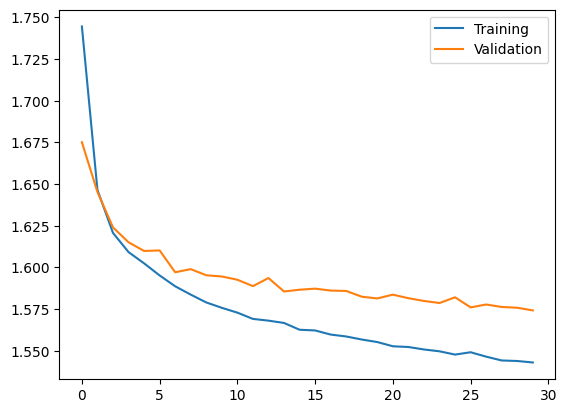

In [13]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Training','Validation'])

In [14]:
testiter = iter(testloader)
images, labels = next(testiter)

In [15]:

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [16]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

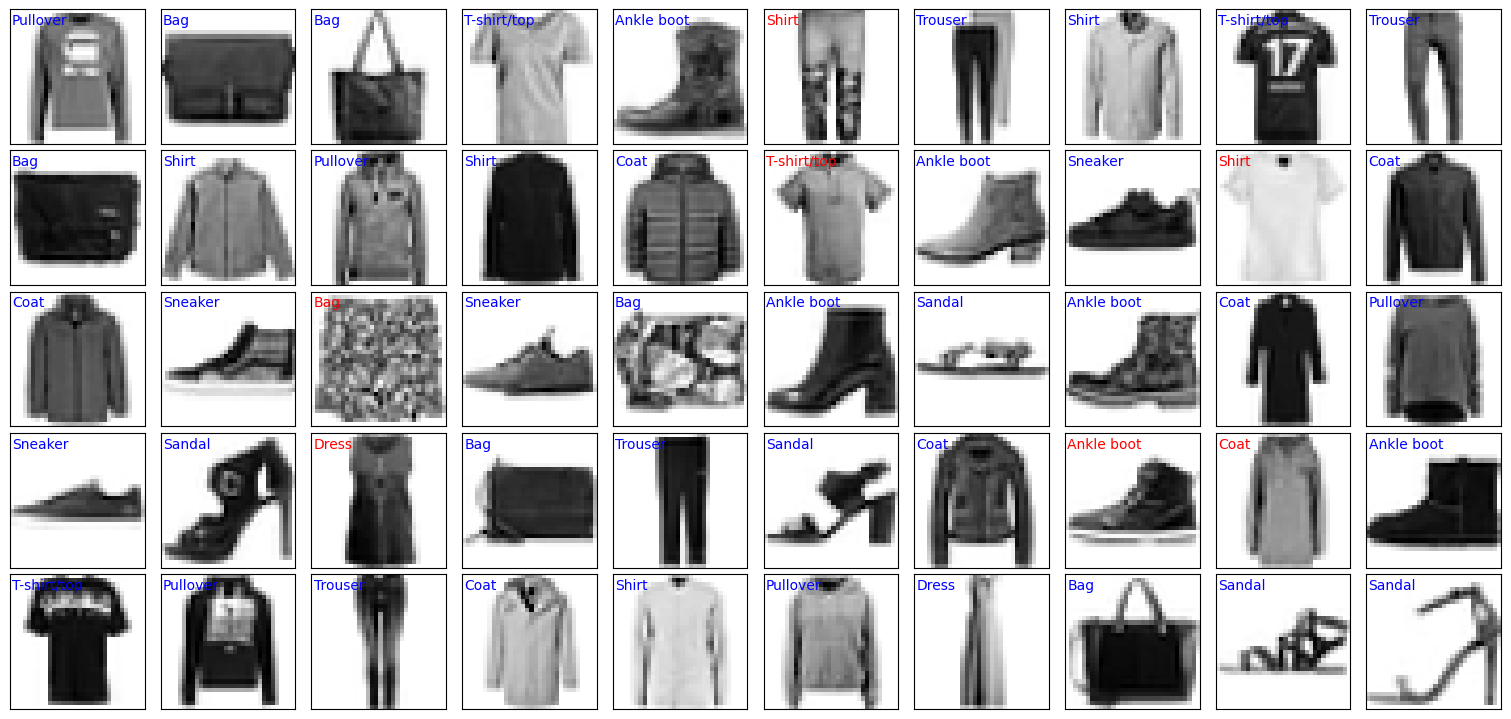

In [17]:

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')